<a href="https://colab.research.google.com/github/lunaB/AI-Experiment/blob/master/gan_font__interpolation_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REF
- https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
- https://realblack0.github.io/2020/05/11/transpose-convolution.html
- https://hyunlee103.tistory.com/63
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://stackoverflow.com/questions/62133737/how-does-pytorchs-loss-backward-work-when-retain-graph-true-is-specified (detach)
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795

In [261]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import pickle


# draw
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color=255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)

    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    # 해당 font에 글자 없을시
    if flag == 255 * 128 * 128:
        print('[warning] 폰트 없음 :', ch)
        return None

    if w>canvas_size or h>canvas_size:
        print('[warning] 사이즈를 맞춰주세요')

    return image

# ttf to pickle
def ttf_to_pkl(font_path, pkl_path, canvas_size=128, font_size=90):
    font = ImageFont.truetype(font=font_path, size=font_size)
    upper = "A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z"
    lower = "a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z"
    # number = "0, 1, 2, 3, 4, 5, 6, 7, 8, 9"
    
    # text = (upper+', '+lower+', '+number).split(", ")
    text = (upper+', '+lower).split(", ")

    text_img = []

    for i in text:
        img = draw_single_char(i, font, canvas_size)
        text_img.append(np.array(img))

    with open(pkl_path, 'wb') as f:
        pickle.dump(text_img, f)

    # print(np.array(text_img).shape)
    # plt.imshow(text_img[0], cmap='gray')
    # plt.show()

In [262]:
def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        cs = 64

        # in, out, k, s, p, d
        self.e1 = nn.Sequential(
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8)
        )
        self.e7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            # nn.BatchNorm2d(cs*8)
        )

        self.e1.apply(init_weights)
        self.e2.apply(init_weights)
        self.e3.apply(init_weights)
        self.e4.apply(init_weights)
        self.e5.apply(init_weights)
        self.e6.apply(init_weights)
        self.e7.apply(init_weights)

    def forward(self, x):
        d = dict()
        x = self.e1(x)
        d['e1'] = x
        x = self.e2(x)
        d['e2'] = x
        x = self.e3(x)
        d['e3'] = x
        x = self.e4(x)
        d['e4'] = x
        x = self.e5(x)
        d['e5'] = x
        x = self.e6(x)
        d['e6'] = x
        x = self.e7(x)
        d['e7'] = x
        return x, d

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        cs = 64

        # 128 = style vector
        self.d1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8+128, cs*8, 3, 1, 1), # e1이랑 합치기위해 유지
            # nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*4, cs, 4, 2, 1),
            nn.BatchNorm2d(cs),
        )
        self.d8 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*2, 1, 4, 2, 1),
            # nn.BatchNorm2d(cs),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.d5.apply(init_weights)
        self.d6.apply(init_weights)
        self.d7.apply(init_weights)
        self.d8.apply(init_weights)

    def forward(self, x, e):
        x = self.d1(x)
        x = torch.cat((x, e['e7']), dim=1)
        x = self.d2(x)
        x = torch.cat((x, e['e6']), dim=1)
        x = self.d3(x)
        x = torch.cat((x, e['e5']), dim=1)
        x = self.d4(x)
        x = torch.cat((x, e['e4']), dim=1)
        x = self.d5(x)
        x = torch.cat((x, e['e3']), dim=1)
        x = self.d6(x)
        x = torch.cat((x, e['e2']), dim=1)
        x = self.d7(x)
        x = torch.cat((x, e['e1']), dim=1)
        x = self.d8(x)
        x = torch.tanh(x)
        return x

class Generator(nn.Module):
    def __init__(self, En, De):
        super(Generator, self).__init__()
        self.En = En()
        self.De = De()

    def forward(self, x, vec):
        x, d = self.En(x)
        x = torch.cat((x, vec), dim=1)
        x = self.De(x, d)
        return x

class Discriminator(nn.Module):
    def __init__(self, category_num):
        super(Discriminator, self).__init__()
        cs = 64

        self.category_num = category_num

        self.d1 = nn.Sequential(
            # nn.LeakyReLU(0.2),
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.fc_tf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, 1),
        )
        self.fc_cg = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, category_num),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.fc_tf.apply(init_weights)
        self.fc_cg.apply(init_weights)

    def forward(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)

        tf = self.fc_tf(x)
        cg = self.fc_cg(x)

        return tf, cg

In [307]:
ttf_to_pkl('NanumGothic-Regular.ttf', 'NanumGothic-Regular.pkl')
source = load_pkl('NanumGothic-Regular.pkl')
source = np.array(source)

ttf_to_pkl('Langar-Regular.ttf', 'Langar-Regular.pkl')
ttf_to_pkl('Audiowide-Regular.ttf', 'Audiowide-Regular.pkl')
t1 = load_pkl('Langar-Regular.pkl')
t2 = load_pkl('Audiowide-Regular.pkl')
target = np.array([t1, t2])
print(source.shape, target.shape)

(52, 128, 128) (2, 52, 128, 128)


# 데이터 전처리


In [308]:
from torch.utils.data import DataLoader, TensorDataset

source_tensor = torch.FloatTensor(source) / 255
target_tensor = torch.FloatTensor([t1, t2]) / 255
print(source_tensor.shape, target_tensor.shape)

cg_num = target_tensor.shape[0]
font_num = target_tensor.shape[1]

x_data = torch.FloatTensor(source_tensor).repeat(2, 1, 1).reshape((cg_num * font_num, 1, 128, 128))
t_data = torch.FloatTensor(target_tensor).reshape((cg_num * font_num, 1, 128, 128))
t_meta = torch.LongTensor([[i, j] for j in range(font_num) for i in range(cg_num)]) # [cg, font]
c_vec = np.random.normal(size=(cg_num, 128, 1, 1))

c_vec_t = torch.FloatTensor([c_vec[i] for _ in range(font_num) for i in range(cg_num)])

x_data = x_data.cuda()
t_data = t_data.cuda()
x_meta = x_meta
c_vec_t = c_vec_t.cuda()

print(x_data.shape)
print(x_meta.shape)
print(c_vec.shape)
print(c_vec_t.shape)

torch.Size([52, 128, 128]) torch.Size([2, 52, 128, 128])
torch.Size([104, 1, 128, 128])
torch.Size([104, 2])
(2, 128, 1, 1)
torch.Size([104, 128, 1, 1])


# 학습

batch_size: 30, category_num: 2, font_num: 52
epoch: 1/150	g_loss: 1893.681549	d_loss: 20.180674
epoch: 2/150	g_loss: 888.435242	d_loss: 8.175464
epoch: 3/150	g_loss: 512.176132	d_loss: 8.295233
epoch: 4/150	g_loss: 330.975449	d_loss: 5.033802
epoch: 5/150	g_loss: 246.427971	d_loss: 2.694045
epoch: 6/150	g_loss: 207.543602	d_loss: 2.254582
epoch: 7/150	g_loss: 195.239006	d_loss: 2.619855
epoch: 8/150	g_loss: 182.561474	d_loss: 2.040666
epoch: 9/150	g_loss: 183.691631	d_loss: 2.114625
epoch: 10/150	g_loss: 180.517662	d_loss: 1.471768
유사도 tensor(1.)


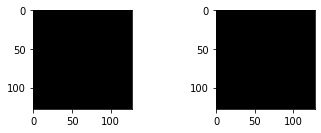

epoch: 11/150	g_loss: 179.180351	d_loss: 1.557725
epoch: 12/150	g_loss: 175.305584	d_loss: 1.587676
epoch: 13/150	g_loss: 172.119587	d_loss: 1.196494
epoch: 14/150	g_loss: 170.396076	d_loss: 1.093655
epoch: 15/150	g_loss: 166.253407	d_loss: 1.059018
epoch: 16/150	g_loss: 167.236591	d_loss: 1.173937
epoch: 17/150	g_loss: 166.440830	d_loss: 1.460353
epoch: 18/150	g_loss: 164.135262	d_loss: 1.375016
epoch: 19/150	g_loss: 165.959782	d_loss: 1.073760
epoch: 20/150	g_loss: 159.375507	d_loss: 0.981766
유사도 tensor(0.9965)


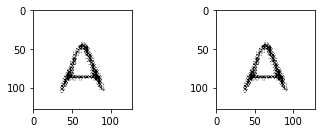

epoch: 21/150	g_loss: 162.699348	d_loss: 1.105045
epoch: 22/150	g_loss: 158.720852	d_loss: 0.635579
epoch: 23/150	g_loss: 160.367413	d_loss: 0.497705
epoch: 24/150	g_loss: 161.738411	d_loss: 0.394590
epoch: 25/150	g_loss: 159.329197	d_loss: 0.388167
epoch: 26/150	g_loss: 159.718830	d_loss: 0.244759
epoch: 27/150	g_loss: 160.198757	d_loss: 0.220792
epoch: 28/150	g_loss: 154.472794	d_loss: 0.113565
epoch: 29/150	g_loss: 155.646172	d_loss: 0.160429
epoch: 30/150	g_loss: 159.585732	d_loss: 0.653146
유사도 tensor(0.9964)


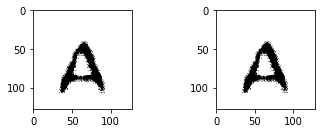

epoch: 31/150	g_loss: 157.695133	d_loss: 0.855295
epoch: 32/150	g_loss: 156.749199	d_loss: 0.410842
epoch: 33/150	g_loss: 160.965809	d_loss: 0.356431
epoch: 34/150	g_loss: 156.978409	d_loss: 0.218131
epoch: 35/150	g_loss: 155.119991	d_loss: 0.218488
epoch: 36/150	g_loss: 151.806499	d_loss: 0.159705
epoch: 37/150	g_loss: 152.893761	d_loss: 0.095863
epoch: 38/150	g_loss: 151.649204	d_loss: 0.093770
epoch: 39/150	g_loss: 148.611599	d_loss: 0.033205
epoch: 40/150	g_loss: 149.302620	d_loss: 0.039234
유사도 tensor(0.9968)


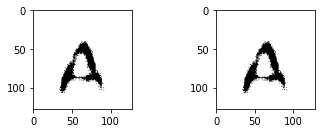

epoch: 41/150	g_loss: 149.565895	d_loss: 0.019590
epoch: 42/150	g_loss: 150.862843	d_loss: 0.021322
epoch: 43/150	g_loss: 151.714336	d_loss: 0.028007
epoch: 44/150	g_loss: 149.617821	d_loss: 0.021479
epoch: 45/150	g_loss: 146.892956	d_loss: 0.015662
epoch: 46/150	g_loss: 148.821083	d_loss: 0.028644
epoch: 47/150	g_loss: 148.783443	d_loss: 0.012573
epoch: 48/150	g_loss: 146.973347	d_loss: 0.015696
epoch: 49/150	g_loss: 148.071716	d_loss: 0.015576
epoch: 50/150	g_loss: 146.613224	d_loss: 0.011599
유사도 tensor(0.9898)


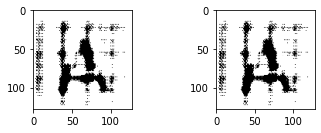

epoch: 51/150	g_loss: 149.499249	d_loss: 0.007226
epoch: 52/150	g_loss: 147.039780	d_loss: 0.010331
epoch: 53/150	g_loss: 144.718128	d_loss: 0.010528
epoch: 54/150	g_loss: 144.565891	d_loss: 0.021441
epoch: 55/150	g_loss: 144.850449	d_loss: 0.012203
epoch: 56/150	g_loss: 142.982670	d_loss: 0.016108
epoch: 57/150	g_loss: 143.252846	d_loss: 0.008034
epoch: 58/150	g_loss: 147.163532	d_loss: 0.011209
epoch: 59/150	g_loss: 148.124329	d_loss: 0.010016
epoch: 60/150	g_loss: 143.843998	d_loss: 0.086266
유사도 tensor(0.9969)


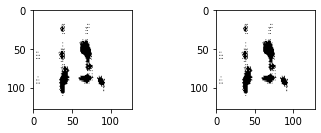

epoch: 61/150	g_loss: 149.210976	d_loss: 0.062126
epoch: 62/150	g_loss: 146.791824	d_loss: 0.041717
epoch: 63/150	g_loss: 146.908497	d_loss: 0.020109
epoch: 64/150	g_loss: 146.316547	d_loss: 0.018730
epoch: 65/150	g_loss: 145.600170	d_loss: 0.010492
epoch: 66/150	g_loss: 143.645882	d_loss: 0.008656
epoch: 67/150	g_loss: 145.755539	d_loss: 0.009267
epoch: 68/150	g_loss: 143.445366	d_loss: 0.013631
epoch: 69/150	g_loss: 144.116253	d_loss: 0.047269
epoch: 70/150	g_loss: 142.035179	d_loss: 0.025884
유사도 tensor(0.9991)


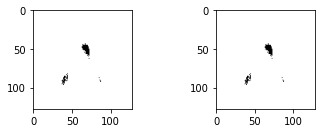

epoch: 71/150	g_loss: 143.591991	d_loss: 0.027814
epoch: 72/150	g_loss: 140.076000	d_loss: 0.009618
epoch: 73/150	g_loss: 140.339687	d_loss: 0.006412
epoch: 74/150	g_loss: 141.181492	d_loss: 0.004019
epoch: 75/150	g_loss: 141.199680	d_loss: 0.004262
epoch: 76/150	g_loss: 145.135933	d_loss: 0.004628
epoch: 77/150	g_loss: 149.846119	d_loss: 0.002240
epoch: 78/150	g_loss: 141.490711	d_loss: 0.005543
epoch: 79/150	g_loss: 142.030087	d_loss: 0.002598
epoch: 80/150	g_loss: 145.241283	d_loss: 0.004235
유사도 tensor(0.9991)


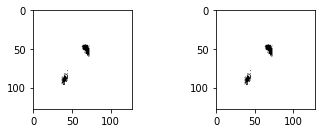

epoch: 81/150	g_loss: 144.357433	d_loss: 0.002534
epoch: 82/150	g_loss: 144.809227	d_loss: 0.002848
epoch: 83/150	g_loss: 142.130119	d_loss: 0.019634
epoch: 84/150	g_loss: 142.539726	d_loss: 0.143031
epoch: 85/150	g_loss: 144.305943	d_loss: 0.065280
epoch: 86/150	g_loss: 141.038204	d_loss: 0.014871
epoch: 87/150	g_loss: 142.771610	d_loss: 0.004694
epoch: 88/150	g_loss: 142.126621	d_loss: 0.006933
epoch: 89/150	g_loss: 143.368771	d_loss: 0.008222
epoch: 90/150	g_loss: 141.936367	d_loss: 0.005272
유사도 tensor(1.)


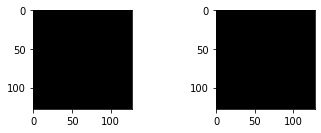

In [ ]:
epochs = 150
batch_size = 30

ds = TensorDataset(x_data, t_data, t_meta, c_vec_t)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

encoder = Encoder().cuda()
decoder = Decoder().cuda()
discriminator = Discriminator(category_num=cg_num).cuda()

encoder.train()
decoder.train()
discriminator.train()

l1_criterion = nn.L1Loss().cuda()
bce_criterion = nn.BCEWithLogitsLoss().cuda()
ce_criterion = nn.CrossEntropyLoss().cuda()
mse_criterion = nn.MSELoss().cuda()

g_optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

L1_W = 500
MSE_W = 1000


print('batch_size: %d, category_num: %d, font_num: %d'%(batch_size, cg_num, font_num))

log = []

for epoch in range(epochs):
    
    encoder.train()
    decoder.train()

    d_total_loss = []
    g_total_loss = []


    l1_loss_arr = []
    ff_bce_loss_arr = []
    bce_loss_arr = []
    ce_loss_arr = []
    z_loss_arr = []

    for x, t, tm, c in loader:
        # print(x.shape, xm.shape, c.shape)

        cg = tm.T[0]
        font = tm.T[0]

        z, e_net = encoder(x)
        d_in = torch.cat((z, c), dim=1)
        d_out = decoder(d_in, e_net)
        # print(z.shape, d_in.shape, d_out.shape)

        real_tf, real_cg = discriminator(t)
        fake_tf, fake_cg = discriminator(d_out)

        # 정답 텐서
        one_tensor = torch.ones(x.shape[0], 1).cuda()
        zero_tensor = torch.ones(x.shape[0], 1).cuda()

        # [dis] 가짜 검출 로스
        r_bce_loss = bce_criterion(real_tf, one_tensor)
        f_bce_loss = bce_criterion(fake_tf, zero_tensor)
        bce_loss = r_bce_loss + f_bce_loss
        
        # [dis] 카테고리 예측 로스
        category = torch.FloatTensor(np.array(np.eye(cg_num)[cg])).cuda() 
        r_ce_loss = bce_criterion(real_cg, category)
        f_ce_loss = bce_criterion(fake_cg, category) # 카테고리 예측 로스
        ce_loss = 0.5*(r_ce_loss + f_ce_loss)

        # [gen.en] z vector 유사도 로스
        t_z = encoder(t)[0]
        z_loss = mse_criterion(z, t_z)

        # [gen] 타겟 유사도 로스
        l1_loss = l1_criterion(d_out, t)

        # [gen] 변조 성공 로스
        ff_bce_loss = bce_criterion(fake_tf, one_tensor)

        # loss grad
        g_loss = (L1_W * l1_loss) + ff_bce_loss + (MSE_W * z_loss) + f_ce_loss
        d_loss = bce_loss + ce_loss

        # generator
        encoder.zero_grad()
        decoder.zero_grad()
        g_loss.backward(retain_graph=True)

        # discriminator
        discriminator.zero_grad()
        d_loss.backward(retain_graph=True)

        g_optimizer.step()
        d_optimizer.step()

        # log
        d_total_loss.append(d_loss.item())
        g_total_loss.append(g_loss.item())

        l1_loss_arr.append(l1_loss.item())
        ff_bce_loss_arr.append(f_tf_bce_loss.item())
        bce_loss_arr.append(bce_loss.item())
        ce_loss_arr.append(ce_loss.item())
        z_loss_arr.append(z_loss.item())
    log.append([d_total_loss, g_total_loss, l1_loss_arr, ff_bce_loss_arr, bce_loss_arr, ce_loss_arr, z_loss_arr])

    print('epoch: %d/%d\tg_loss: %f\td_loss: %f'%(epoch+1, epochs, sum(g_total_loss), sum(d_total_loss)))
    if (epoch+1) % 10 == 0:
        gprint(0, 0, 1)

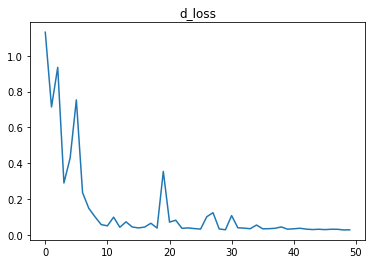

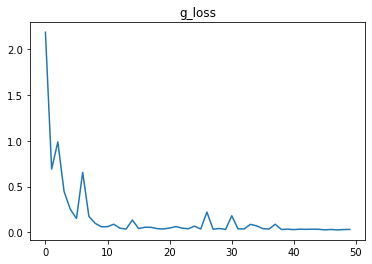

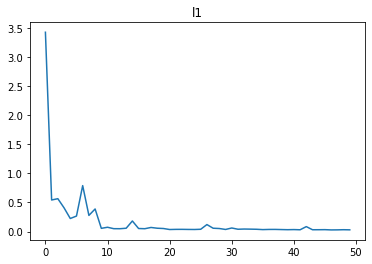

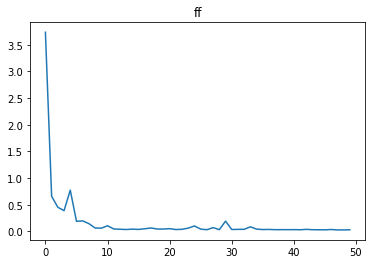

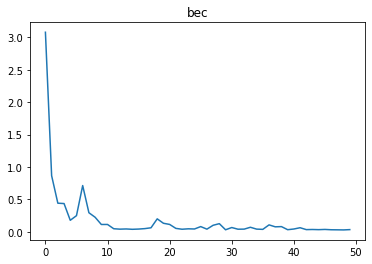

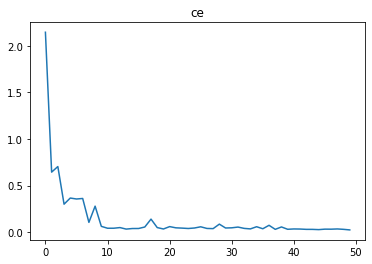

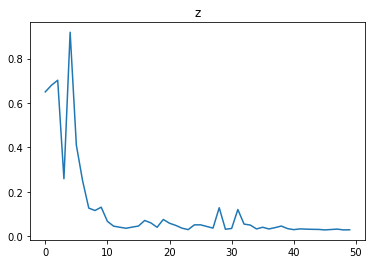

In [301]:
log = np.array(log)
n = ['d_loss','g_loss','l1', 'ff', 'bec', 'ce', 'z']
plt.tight_layout()
for i in range(len(n)):
    x = np.linspace(0, 50, 50)
    plt.title(n[i])
    y1 = log.T[i].max(0)
    y2 = log.T[i].min(0)
    plt.fill_between(x, y1, y2, where=(y1 > y2), alpha=0.2)
    plt.plot(log.T[i].mean(0))
    plt.show()

유사도 tensor(0.9950)


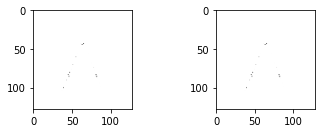

In [106]:
def generate(ch, style):
    encoder.eval()
    decoder.eval()
    x = torch.FloatTensor(source[ch]).reshape((1, 1, 128, 128)).cuda()
    c = torch.FloatTensor(c_vec[style]).reshape((1, 128, 1, 1)).cuda()
    # print(c.shape)
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach()
    # print(d_out.shape)
    # print(d_out)
    image = d_out.cpu()

    return image

def gprint(ch, s1, s2):
    g1 = generate(ch, s1)
    g2 = generate(ch, s2)
    print('유사도', (g1 == g2).float().mean())
    plt.subplot(221)
    plt.imshow(g1.numpy()[0, 0], cmap='gray')
    plt.subplot(222)
    plt.imshow(g2.numpy()[0, 0], cmap='gray')
    plt.show()

gprint(0, 0, 1)

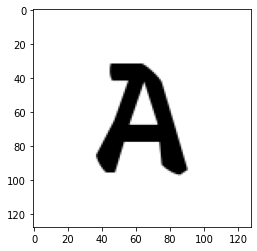

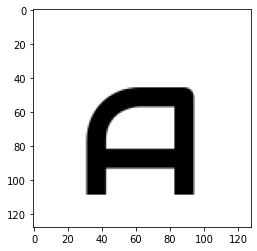

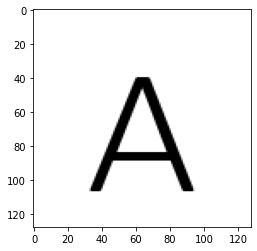

In [11]:
# t
plt.imshow(target[0, 0], cmap='gray')
plt.show()
plt.imshow(target[1, 0], cmap='gray')
plt.show()
plt.imshow(source[0], cmap='gray')
plt.show()

In [12]:
# Test
gx = torch.FloatTensor([source[0]]).reshape((-1,1,128,128)) / 255
style_vector = torch.FloatTensor(np.random.normal(size=(1, 128, 1, 1)))

generator = Generator(En, De)
gy = generator(gx, style_vector)

dx = gy
print(dx.shape)
print(dx)
descriminator = Discriminator(category_num=2)
dy = descriminator(dx)
print(dy[1].shape)
print(dy[2].shape)

plt.imshow(source[0], cmap='gray')
plt.show()
plt.imshow(gy.detach().numpy()[0,0], cmap='gray')
plt.show()

NameError: ignored

In [16]:
# 실험 1
# vector = np.random.normal(size=(1, 128, 1, 1))
vector1 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector2 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector3 = torch.FloatTensor(np.random.normal(size=(1, 128)))

In [17]:
print(torch.cdist(vector1, vector2))
print(torch.cdist(vector1, vector3))

tensor([[16.1609]])
tensor([[15.4466]])


In [18]:
a = np.array([[-6,-2,-4]]) 
b = np.array([[1,3,2]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

print(0, c)
di = 1/3
print(1, c + (d - c) * di)
di = 2/3
print(2, c + (d - c) * di)
print(3, d)

print('distence:', torch.cdist(c, d, 1))

0 tensor([[-6., -2., -4.]])
1 tensor([[-3.6667, -0.3333, -2.0000]])
2 tensor([[-1.3333,  1.3333,  0.0000]])
3 tensor([[1., 3., 2.]])
distence: tensor([[18.]])


distence: tensor([[4.]])


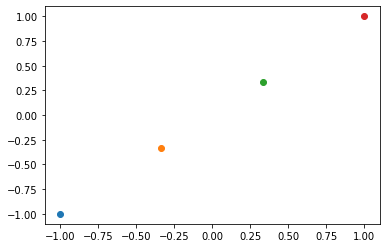

In [19]:
a = np.array([[-1,-1]]) 
b = np.array([[1,1]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

def sub_distence(a, b, s):
    return a + (b - a) * s

print('distence:', torch.cdist(c, d, 1))
n = 4
for i in range(n):
    sp = sub_distence(c, d, i/(n-1)).numpy()[0]
    plt.scatter(sp[0], sp[1])
plt.show()

In [ ]:
# t
plt.imshow(target[1,1], cmap='gray')
plt.show()
plt.imshow(source[1], cmap='gray')
plt.show()